In [14]:
import pandas as pd
import peakutils
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [15]:
# create giant data object, to house all data
data = {}

In [16]:
# read all the labels for the data into a df
def read_labels_for_all_houses():
    houses = []
    for house in range(1, 7):
        hi = 'Data/low_freq/house_{}/labels.dat'.format(house)
        df = pd.read_csv(hi, sep=" ", header=None, names = ["appliance_id","appliance_name"], dtype={"appliance_id":"int64","appliance_name":"string"})
        df['house_id'] = house
        houses.append(df)
    return pd.concat(houses).reset_index(drop=True)

labels = read_labels_for_all_houses()
for house in range(1,7):
    print('House {}: \n'.format(house), labels[labels['house_id'] == house] , '\n')

data['labels_for_houses'] = labels

House 1: 
     appliance_id   appliance_name  house_id
0              1            mains         1
1              2            mains         1
2              3             oven         1
3              4             oven         1
4              5     refrigerator         1
5              6        dishwaser         1
6              7  kitchen_outlets         1
7              8  kitchen_outlets         1
8              9         lighting         1
9             10     washer_dryer         1
10            11        microwave         1
11            12     bathroom_gfi         1
12            13    electric_heat         1
13            14            stove         1
14            15  kitchen_outlets         1
15            16  kitchen_outlets         1
16            17         lighting         1
17            18         lighting         1
18            19     washer_dryer         1
19            20     washer_dryer         1 

House 2: 
     appliance_id   appliance_name  house_id
20      

In [17]:
# read all the appliance data points for all houses
def read_channel_data(labels_for_houses, house_id):
    house_labels = labels_for_houses[labels_for_houses['house_id'] == house_id]
    # print(house_labels)
    df = pd.DataFrame()
    for index,row in house_labels.reset_index().iterrows():
        path = 'data/low_freq/house_{}/'.format(house_id)
        file = path + 'channel_{}.dat'.format(row['appliance_id'])
        cname = (row['house_id'], row['appliance_id'], row['appliance_name'])
        file_content = pd.read_table(file, sep = ' ', names = ['unix_time', cname], 
                                        dtype = {'unix_time': 'int64', cname:'float64'})
        if(index==0):
            df = file_content
        else:
            df = pd.merge(df, file_content, how='inner', on='unix_time')
    
    df['timestamp'] = df['unix_time'].astype("datetime64[s]")
    df = df.set_index(df['timestamp'].values)
    df.drop(['unix_time','timestamp'], axis=1, inplace=True)
    df.columns = pd.MultiIndex.from_tuples(df.columns, names=["house_id","appliance_id", "appliance_name"])
    return df

# print(data['labels_for_houses'])
data['channels'] = {}
dfs = []
for house in range(1,7):
    print('reading channels for house {}'.format(house))
    # data['channels'][house] = read_channel_data(data['labels_for_houses'], house)
    df = read_channel_data(data['labels_for_houses'], house)
    # print(df.head())
    dfs.append(df)

appliance_data = pd.concat(dfs, axis=1)
print(appliance_data.columns)


reading channels for house 1
reading channels for house 2
reading channels for house 3
reading channels for house 4
reading channels for house 5
reading channels for house 6
MultiIndex([(1,  1,            'mains'),
            (1,  2,            'mains'),
            (1,  3,             'oven'),
            (1,  4,             'oven'),
            (1,  5,     'refrigerator'),
            (1,  6,        'dishwaser'),
            (1,  7,  'kitchen_outlets'),
            (1,  8,  'kitchen_outlets'),
            (1,  9,         'lighting'),
            (1, 10,     'washer_dryer'),
            ...
            (6,  8,     'refrigerator'),
            (6,  9,        'dishwaser'),
            (6, 10,  'outlets_unknown'),
            (6, 11,  'outlets_unknown'),
            (6, 12,    'electric_heat'),
            (6, 13,  'kitchen_outlets'),
            (6, 14,         'lighting'),
            (6, 15, 'air_conditioning'),
            (6, 16, 'air_conditioning'),
            (6, 17, 'air_condit

In [18]:
# example of indexing with multiindex columns


# print columns
print(appliance_data.columns)

# print only names
print(appliance_data.columns.get_level_values('appliance_name'))

# print only appliance ids
print(appliance_data.columns.get_level_values('appliance_id'))


# print only ids
print(appliance_data.columns.get_level_values('house_id'))

# index using appliance name 
print(appliance_data.xs('mains',level='appliance_name', axis=1).head())

# and using appliance id
print(appliance_data.xs(2,level='appliance_id', axis=1).head())

# index column based on position
print(appliance_data.iloc[:,1].head())


MultiIndex([(1,  1,            'mains'),
            (1,  2,            'mains'),
            (1,  3,             'oven'),
            (1,  4,             'oven'),
            (1,  5,     'refrigerator'),
            (1,  6,        'dishwaser'),
            (1,  7,  'kitchen_outlets'),
            (1,  8,  'kitchen_outlets'),
            (1,  9,         'lighting'),
            (1, 10,     'washer_dryer'),
            ...
            (6,  8,     'refrigerator'),
            (6,  9,        'dishwaser'),
            (6, 10,  'outlets_unknown'),
            (6, 11,  'outlets_unknown'),
            (6, 12,    'electric_heat'),
            (6, 13,  'kitchen_outlets'),
            (6, 14,         'lighting'),
            (6, 15, 'air_conditioning'),
            (6, 16, 'air_conditioning'),
            (6, 17, 'air_conditioning')],
           names=['house_id', 'appliance_id', 'appliance_name'], length=116)
Index(['mains', 'mains', 'oven', 'oven', 'refrigerator', 'dishwaser',
       'kitchen_

In [19]:
# resample signals
cleaned = appliance_data.resample("3s").median()
cleaned = cleaned.interpolate(method="pad", limit=5)

idx = cleaned.index


In [20]:
def onehouse(df, i):
    house = df.xs(i, level='house_id', axis=1)

    # get the index of the first and last non-null value in each column
    first_non_null = house.apply(lambda x: x.first_valid_index()).values[0]
    last_non_null = house.apply(lambda x: x.last_valid_index()).values[0]
    
    # slice the DataFrame to keep only the rows between the first and last non-null values
    house = house.loc[first_non_null:last_non_null]

    return house

In [21]:
for a in range(1, 7):
    df = onehouse(cleaned, a)
    df.columns = df.columns.droplevel(0) # Drop first level of MultiIndex
    df = df.reset_index(drop=False)
    new_cols = [f"{i}_{col}" for i, col in enumerate(df.columns)] # Create new column names
    df.columns = new_cols # Assign new column names
    df.to_feather("Data/cleaned/house/house_{0}.feather".format(a))


In [22]:
for a in range(1, 7):
    df = onehouse(cleaned, a)
    localmax = df.rolling(10, min_periods=1).max()
    labels = pd.DataFrame().reindex_like(df)
    labels = pd.DataFrame(0, index=labels.index, columns=labels.columns)  # Initialize with 0
    labels[localmax[localmax.index.isin(labels.index)] >= 15] = 1
    
    # Change 0 to NaN where df is NaN
    labels = labels.mask(df.isna(), np.nan)
    
    # Save to feather
    labels.columns = labels.columns.droplevel(0)  # Drop first level of MultiIndex
    labels = labels.reset_index(drop=False)
    new_cols = [f"{i}_{col}" for i, col in enumerate(labels.columns)]  # Create new column names
    labels.columns = new_cols  # Assign new column names
    labels.to_feather("Data/cleaned/labels/labels_{0}.feather".format(a))


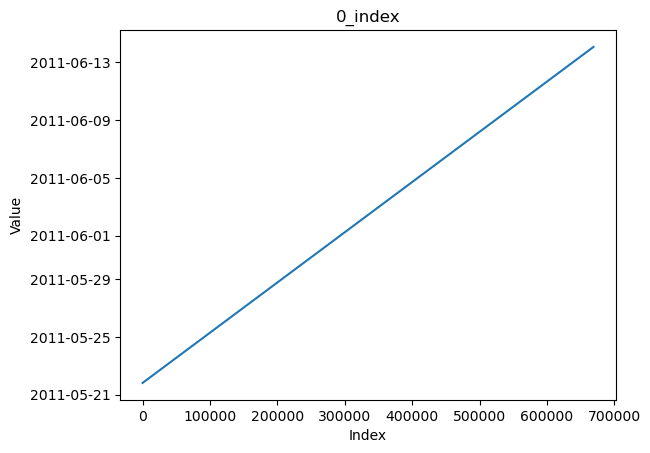

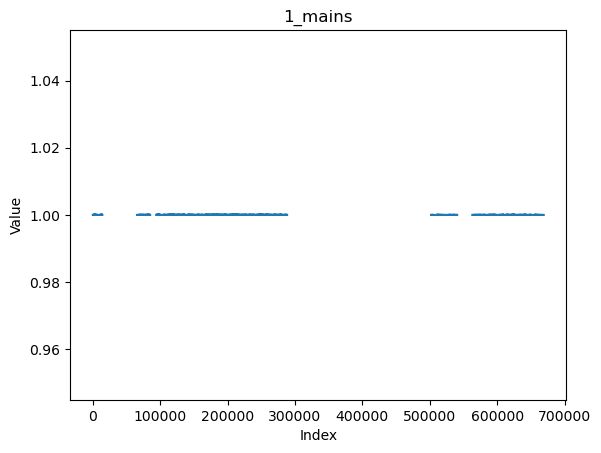

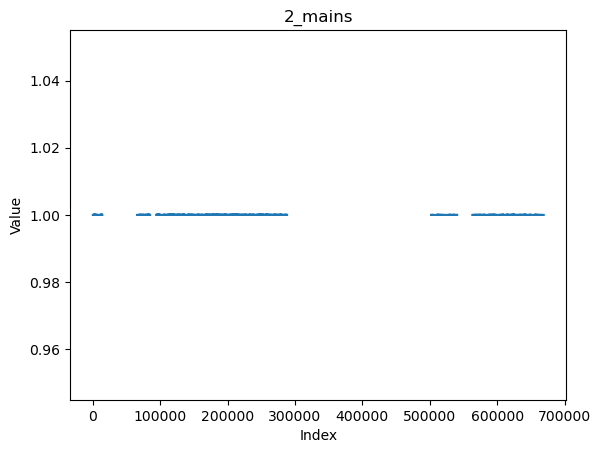

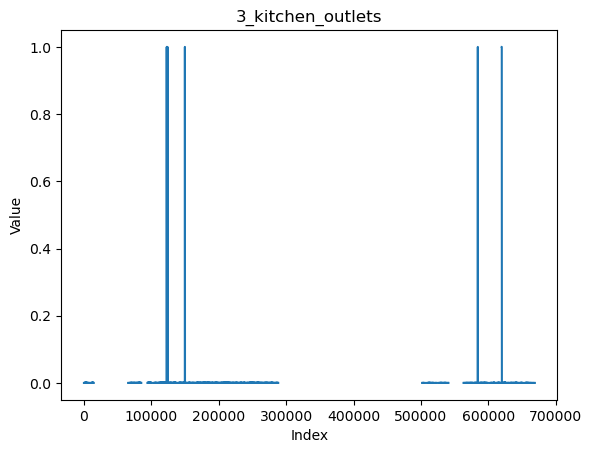

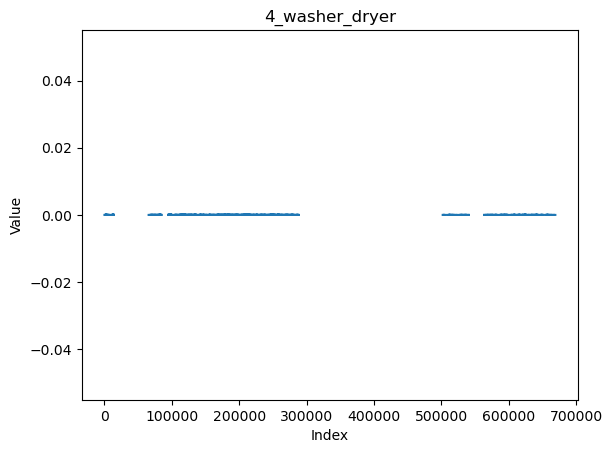

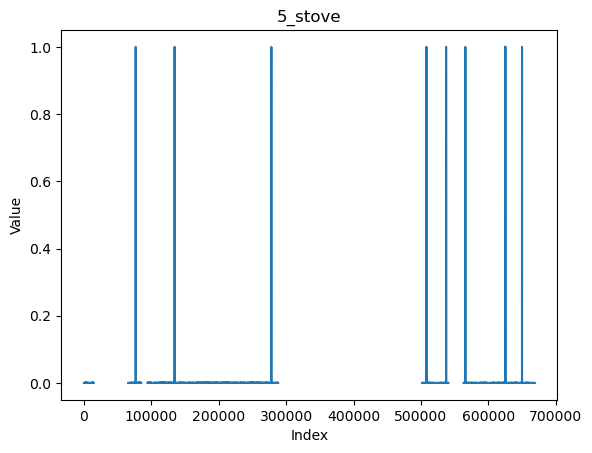

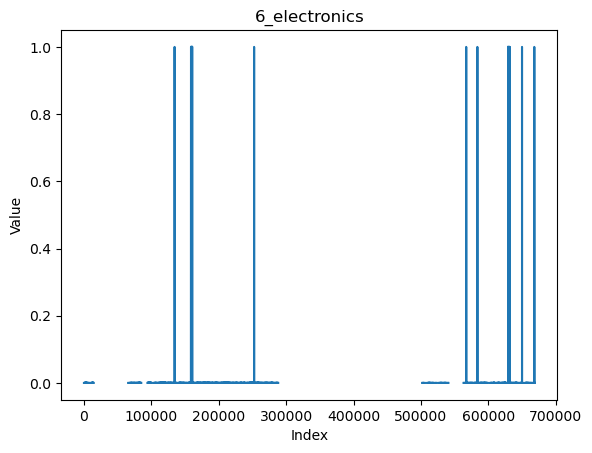

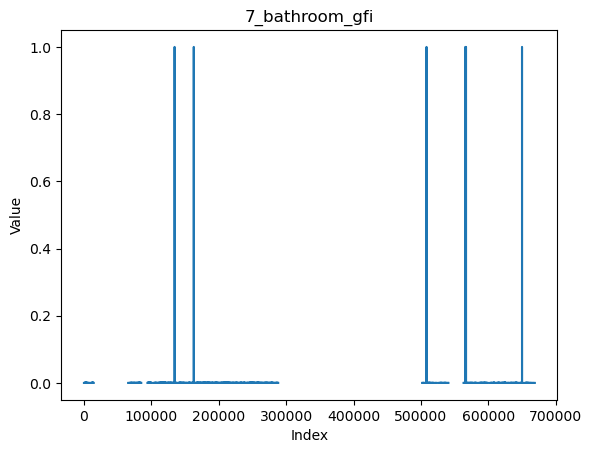

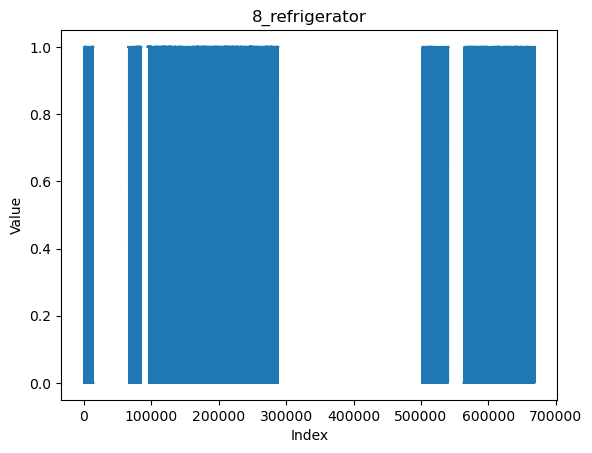

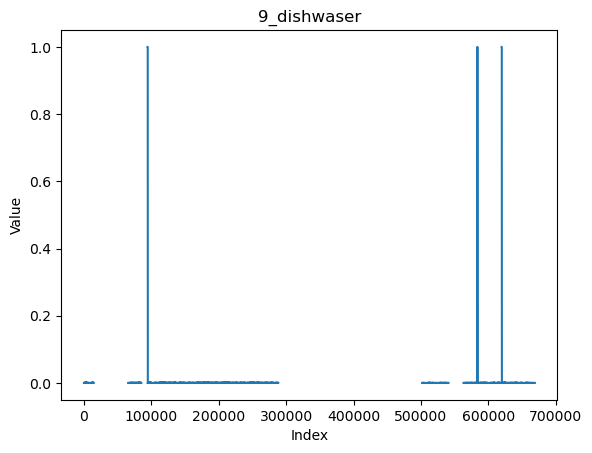

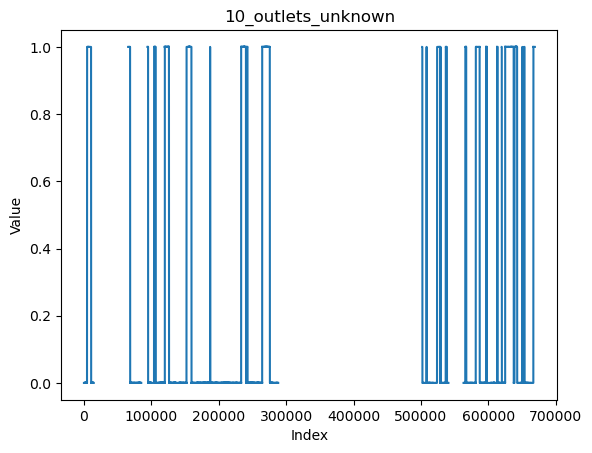

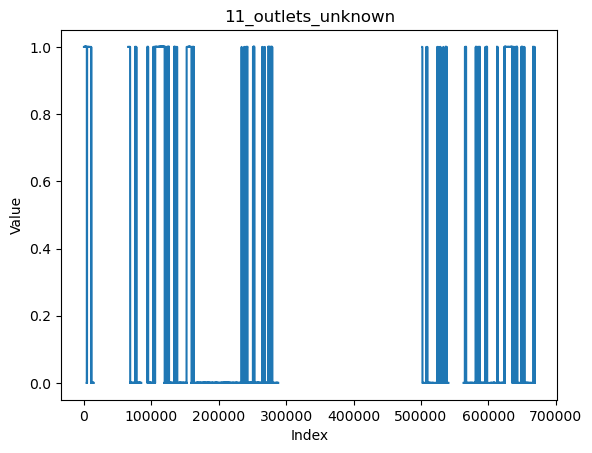

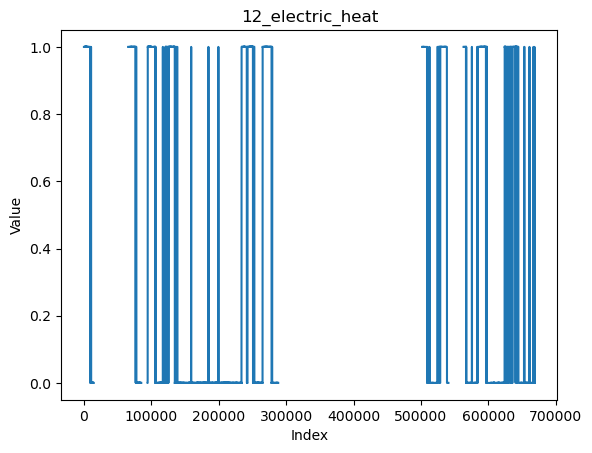

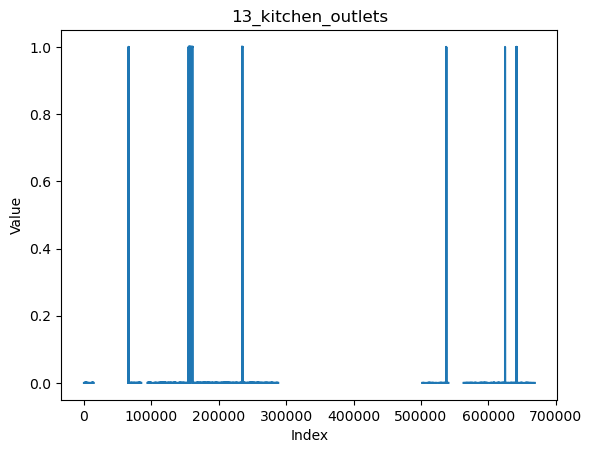

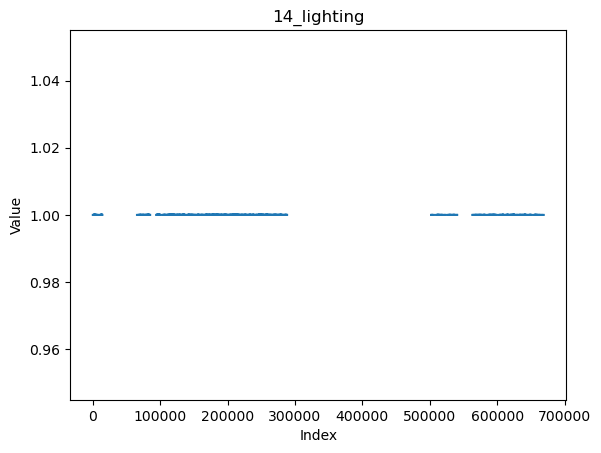

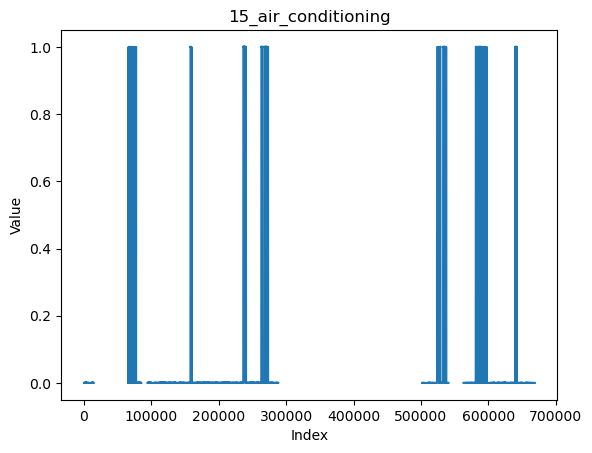

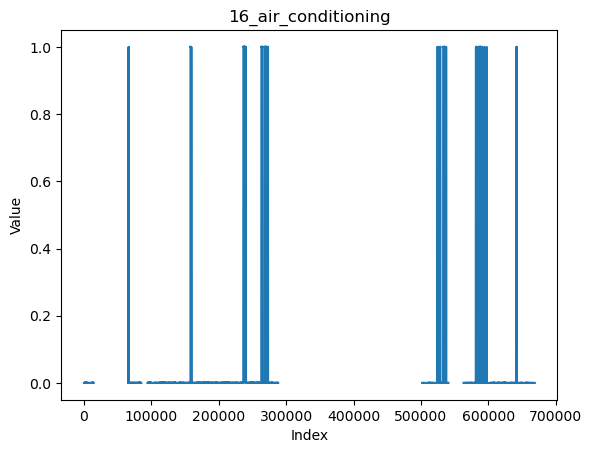

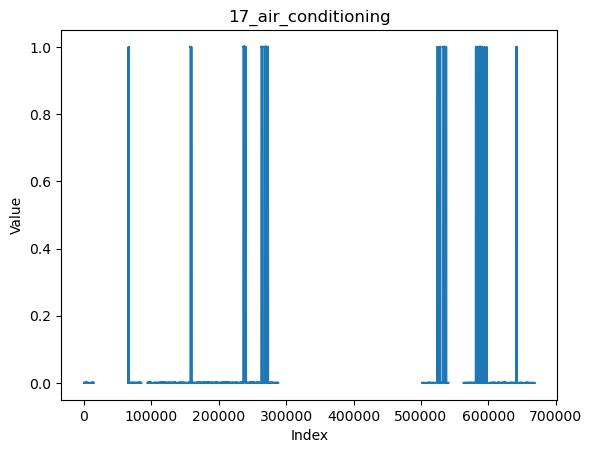

In [23]:
import matplotlib.pyplot as plt

# Iterate over the columns in labels DataFrame
for column in labels.columns:
    # Create a plot for the current column
    plt.figure()
    plt.plot(labels[column])
    plt.title(column)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()
